In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
#load the files
file_names = [
    "Moving_Violations_Issued_in_January_2024.csv",
    "Moving_Violations_Issued_in_February_2024.csv",
    "Moving_Violations_Issued_in_March_2024.csv",
    "Moving_Violations_Issued_in_April_2024.csv",
    "Moving_Violations_Issued_in_May_2024.csv",
    "Moving_Violations_Issued_in_June_2024.csv",
    "Moving_Violations_Issued_in_July_2024.csv",
    "Moving_Violations_Issued_in_August_2024.csv",
    "Moving_Violations_Issued_in_September_2024.csv",
    "Moving_Violations_Issued_in_October_2024.csv",
    "Moving_Violations_Issued_in_November_2024.csv",
    "Moving_Violations_Issued_in_December_2024.csv"
]

#keep only relevant columns
columns_to_keep = [
     "VIOLATION_PROCESS_DESC", "ACCIDENT_INDICATOR", "LATITUDE", "LONGITUDE"
]


all_data = []

#iterate through the files 
for file in file_names:
    df = pd.read_csv(
        file,
        usecols=columns_to_keep,
        dtype={
            "ACCIDENT_INDICATOR": "str"
        },
        low_memory=False
    )
    
    #only keep valid accident indicator values
    df = df[df["ACCIDENT_INDICATOR"].isin(["Y", "N"])]
    
    all_data.append(df)

#combine all months
combined_df = pd.concat(all_data, ignore_index=True)

#optional: Save to CSV
# combined_df.to_csv("combined_moving_violations_2024.csv", index=False)

#verify number of rows of combined data
print(len(combined_df))

#verify column names 
print(combined_df.head())


33917
                             VIOLATION_PROCESS_DESC ACCIDENT_INDICATOR  \
0                          ONE WAY STREET VIOLATION                  N   
1           UNREGISTERED VEHICLE, MORE THAN 30 DAYS                  N   
2           UNREGISTERED VEHICLE, MORE THAN 30 DAYS                  N   
3  OWNER OPERATE OR PERMIT OPERATION OF UNINSRD VEH                  N   
4    FAIL TO STOP PER REGULATIONS FACING RED SIGNAL                  N   

   LATITUDE  LONGITUDE  
0       NaN        NaN  
1    38.886    -77.006  
2    38.890    -76.999  
3    38.964    -77.016  
4    38.871    -77.010  


In [3]:
##CALCULATING ACCIDENT RATES FOR EACH VIOLATION 

#group by 'VIOLATION_PROCESS_DESC' and calculate the total number of violations and the number of accidents
violation_counts = combined_df.groupby('VIOLATION_PROCESS_DESC')['ACCIDENT_INDICATOR'].value_counts().unstack(fill_value=0)

#calculate the accident rate percentage for each violation
violation_counts['ACCIDENT_RATE'] = violation_counts['Y'] / (violation_counts['Y'] + violation_counts['N']) * 100

#sort the results by accident rate in descending order
violation_counts_sorted = violation_counts.sort_values('ACCIDENT_RATE', ascending=False)

#print out the accident rates
print(violation_counts_sorted[['ACCIDENT_RATE']])

ACCIDENT_INDICATOR                                  ACCIDENT_RATE
VIOLATION_PROCESS_DESC                                           
                                                            100.0
DRIVE OVER A FIRE HOSE                                      100.0
OVERTAKING VEHICLE STOPPED AT XWALK FOR PEDESTRIAN          100.0
OPERATING CMV WITH LAMPS/REFLECTORS OBSCURED                100.0
PASSING APPROACHING FIRE APPARATUS                          100.0
...                                                           ...
LESS THAN 18 YRS OLD MANDATORY SEAT BELT VIOL                 0.0
ALTERED TAGS                                                  0.0
INTERSTATE DRIVER UNDER 21 YEARS OF AGE OOS                   0.0
INTERFERE WITH A TRAFFIC SIGNAL DEVICE                        0.0
VIOLATION OF TOWING REGULATIONS                               0.0

[226 rows x 1 columns]


In [4]:
#count occurrences of "DRIVE OVER A FIRE HOSE"
fire_hose_count = combined_df[combined_df["VIOLATION_PROCESS_DESC"] == "DRIVE OVER A FIRE HOSE"].shape[0]

print(f"Number of violations for 'DRIVE OVER A FIRE HOSE': {fire_hose_count}")

Number of violations for 'DRIVE OVER A FIRE HOSE': 1


In [5]:
##CALCULATE ACCIDENT SCORE FOR EACH VIOLATION
##HELPS GIVE WEIGHT TO VIOLATIONS WITH HIGHER OCCURANCES OR ACCIDENT RATES

#group by 'VIOLATION_PROCESS_DESC' and calculate the total number of violations and the number of accidents
violation_counts = combined_df.groupby('VIOLATION_PROCESS_DESC')['ACCIDENT_INDICATOR'].value_counts().unstack(fill_value=0)

#add total column
violation_counts['TOTAL'] = violation_counts['Y'] + violation_counts['N']

#calculate the accident rate percentage for each violation
violation_counts['ACCIDENT_RATE'] = violation_counts['Y'] / violation_counts['TOTAL'] * 100

#filter for violations with at least 50 total occurrences
min_incidents = 50
filtered_violations = violation_counts[violation_counts['TOTAL'] >= min_incidents].copy()

#sort by accident rate
sorted_filtered_violations = filtered_violations.sort_values('ACCIDENT_RATE', ascending=False)

#calculate accident score
sorted_filtered_violations['ACCIDENT_SCORE'] = sorted_filtered_violations['ACCIDENT_RATE'] * sorted_filtered_violations['TOTAL']

#view top few
print(sorted_filtered_violations[['ACCIDENT_RATE', 'TOTAL', 'ACCIDENT_SCORE']].head())


ACCIDENT_INDICATOR                                 ACCIDENT_RATE  TOTAL  \
VIOLATION_PROCESS_DESC                                                    
FAIL TO CONTROL VEHICLE SPEED TO AVOID COLLIDING       88.888889    243   
COLLIDING WITH FIXED OBJECT W/NO DAMAGE OR INJURY      88.405797     69   
FAIL TO YIELD TO ANOTHER  VEHICLE                      85.826772    127   
RIGHT TURN ON RED FAIL YIELD PEDESTRIAN/VEHICLE        78.846154     52   
COLLIDING WITH PEDESTRIAN                              77.586207     58   

ACCIDENT_INDICATOR                                 ACCIDENT_SCORE  
VIOLATION_PROCESS_DESC                                             
FAIL TO CONTROL VEHICLE SPEED TO AVOID COLLIDING          21600.0  
COLLIDING WITH FIXED OBJECT W/NO DAMAGE OR INJURY          6100.0  
FAIL TO YIELD TO ANOTHER  VEHICLE                         10900.0  
RIGHT TURN ON RED FAIL YIELD PEDESTRIAN/VEHICLE            4100.0  
COLLIDING WITH PEDESTRIAN                                  4500.0 

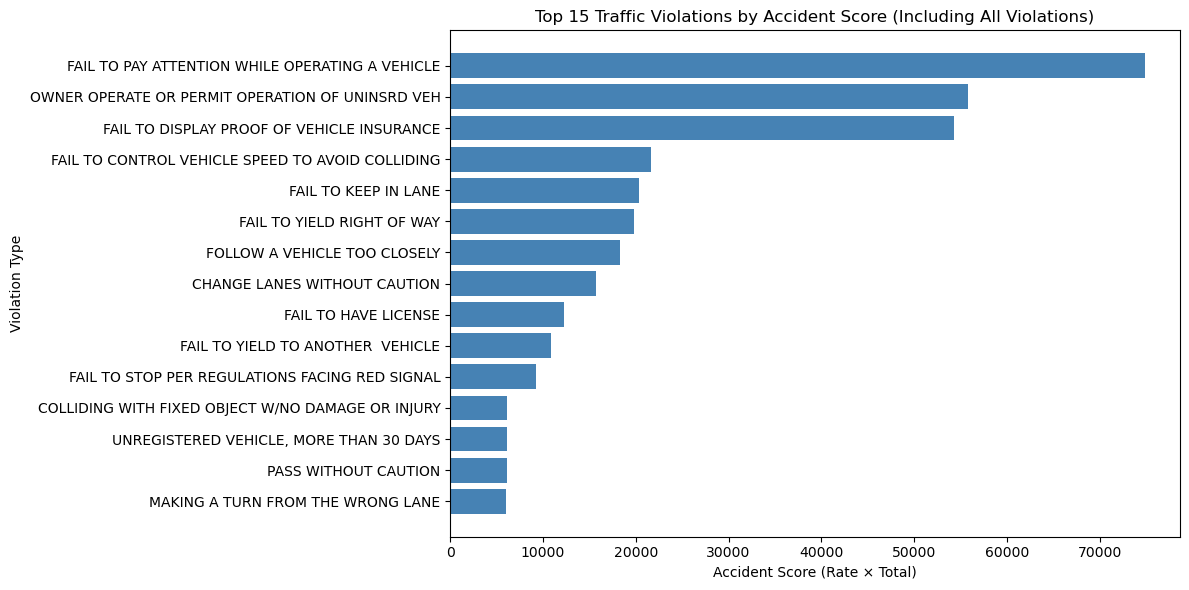

In [6]:
#create a copy to avoid modifying the original
filtered_for_plot = sorted_filtered_violations.copy()

#plot the top violations by accident score
top_full = filtered_for_plot.sort_values('ACCIDENT_SCORE', ascending=False).head(15)

plt.figure(figsize=(12, 6))
plt.barh(top_full.index, top_full['ACCIDENT_SCORE'], color='steelblue')
plt.xlabel("Accident Score (Rate × Total)")
plt.ylabel("Violation Type")
plt.title("Top 15 Traffic Violations by Accident Score (Including All Violations)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [14]:
##NOTICE ABOVE THAT 'COLLIDING WITH FIXED OBJECT W/NO DAMAGE OR INJURY' IS AN ACCIDENT BY NATURE 

#check all the violations to see if any need to be taken out 
unique_violations = combined_df['VIOLATION_PROCESS_DESC'].dropna().unique()
unique_violations.sort()
for violation in unique_violations:
    print(violation)

#there are two 'colliding' violations, we will remove these below

 
ALTERED TAGS
ALTERING A DRIVING PERMIT
ATTEMPTED OPERATING AFTER REVOCATION
BACK UP WITHOUT CAUTION
BACKING TO TURN
BAD FOOT BRAKES
BAD HAND BRAKES
BIKE GIVE FALSE INFORMATION
BIKE/PMD FAIL TO YIELD RIGHT OF WAY  TO PED OR VEH
BUS LANE, UNAUTHRIZED DRIVING IN A
CANCELLED, SUSPENDED, REVOKED, OR ALTERED PERMIT
CARRY PASSENGER OR FAIL TO RIDE ON SEAT
CDL NOT-OUT-OF-SERVICE VIOLATION
CDL OUT-OF-SERVICE VIOLATION
CHANGE LANES WITHOUT CAUTION
COLLIDING WITH FIXED OBJECT W/NO DAMAGE OR INJURY
COLLIDING WITH PEDESTRIAN
COMMERCIAL VEHICLE OPERATING WHILE IN PARK
COVERED LICENSE PLATE
DEAD OR EXPIRED TAGS
DEALER VEHICLE WITHOUT REGISTRATION
DEFECTIVE WINDSHIELD
DISOBEY TRAFFIC CONTROL DEVICE
DISPLAY FAKE INSPECTION STICKER
DISTRACTED DRIVING
DISTRACTED DRIVING USING CELL PHONE, OTHER DEVICE
DRIVE AT UNREASONABLE SPEED
DRIVE CMV W/O PROPER CLASS OR ENDORSEMENTS ON DL
DRIVE OFF THE ROADWAY
DRIVE OVER A FIRE HOSE
DRIVE OVER A SIDEWALK
DRIVE OVER MEDIAN
DRIVE THROUGH OR PASS A BARRICADE
DRIVE TOO

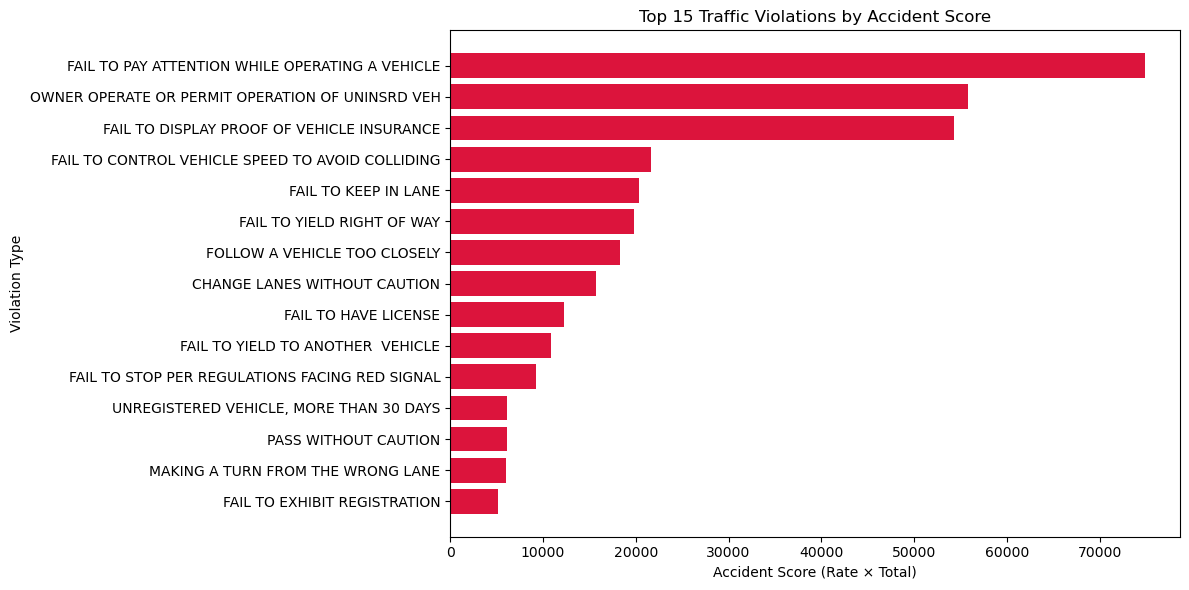

In [8]:
#drop specific unwanted violations (collisions)
filtered_for_plot = filtered_for_plot.drop(
    ['COLLIDING WITH FIXED OBJECT W/NO DAMAGE OR INJURY', 'COLLIDING WITH PEDESTRIAN'],
    errors='ignore'
)

#re-plot the cleaned up version
top_cleaned = filtered_for_plot.sort_values('ACCIDENT_SCORE', ascending=False).head(15)

plt.figure(figsize=(12, 6))
plt.barh(top_cleaned.index, top_cleaned['ACCIDENT_SCORE'], color='crimson')
plt.xlabel("Accident Score (Rate × Total)")
plt.ylabel("Violation Type")
plt.title("Top 15 Traffic Violations by Accident Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [9]:
##GET READY TO CLUSTER BY LOCATION 

#drop any rows that are missing values for latitude or longitude
df_clean = combined_df.dropna(subset=["LATITUDE", "LONGITUDE"]).reset_index(drop=True)

#pepare location data using lat/lon
location_data = df_clean[["LATITUDE", "LONGITUDE"]]

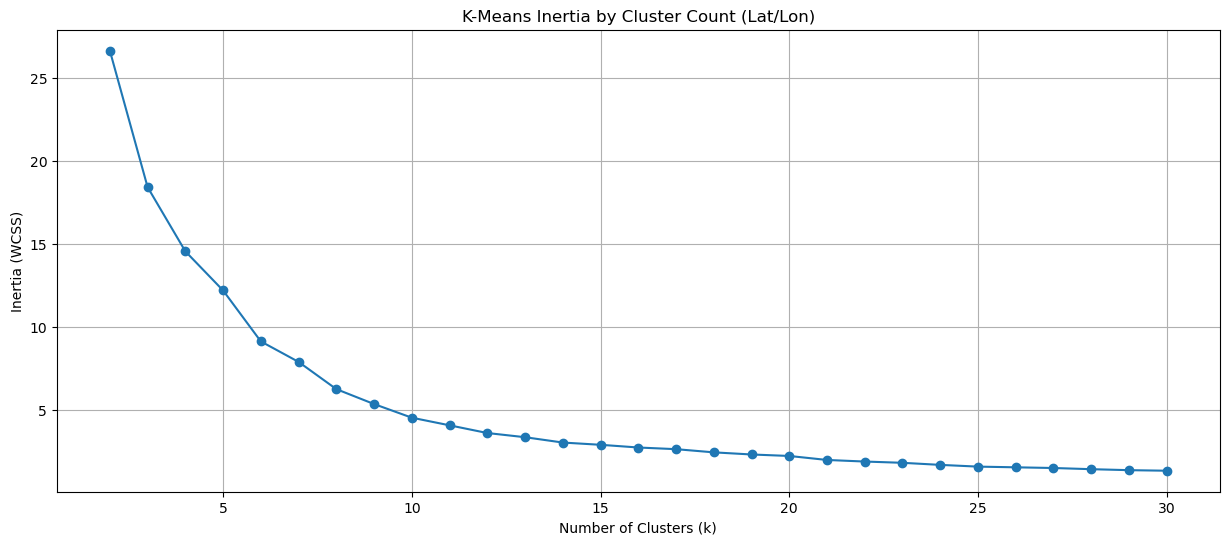

In [16]:
##ELBOW METHOD TO FIND OPTIMAL K VALUE 

inertia_values = []

#find inertia value for each k between 2-30
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(location_data)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(15, 6))
plt.plot(range(2, 31), inertia_values, marker='o')
plt.title('K-Means Inertia by Cluster Count (Lat/Lon)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)
plt.show()

In [11]:
##APPLY K-MEANS WITH OPTIMAL K VALUE 

k_optimal = 15  # Adjust based on elbow plot
kmeans = KMeans(n_clusters=k_optimal, n_init='auto', random_state=42)
df_clean["Location_Cluster"] = kmeans.fit_predict(location_data)

#assign clusters back to combined_df
combined_df.loc[df_clean.index, "Location_Cluster"] = df_clean["Location_Cluster"]

#preview
print(combined_df[["LATITUDE", "LONGITUDE", "Location_Cluster"]].dropna().head())


   LATITUDE  LONGITUDE  Location_Cluster
1    38.886    -77.006               3.0
2    38.890    -76.999               2.0
3    38.964    -77.016               1.0
4    38.871    -77.010               1.0
5    38.888    -77.013               3.0


In [12]:
#drop rows with missing cluster or coordinates
clustered_df = combined_df.dropna(subset=["LATITUDE", "LONGITUDE", "Location_Cluster"]).copy()

#ensure cluster column is integer type
clustered_df["Location_Cluster"] = clustered_df["Location_Cluster"].astype(int)
# Store cluster centers
cluster_centers = []

#within each cluster, find average cluster latitude and longitude
for cluster_id in range(k_optimal):  # Automatically use the chosen number of clusters
    cluster_data = clustered_df[clustered_df["Location_Cluster"] == cluster_id]
    avg_lat = cluster_data["LATITUDE"].mean()
    avg_lon = cluster_data["LONGITUDE"].mean()
    cluster_centers.append((cluster_id, avg_lat, avg_lon))

#print the results
for cluster_id, lat, lon in cluster_centers:
    print(f"Cluster {cluster_id}: {lat:.6f}, {lon:.6f}")

Cluster 0: 38.902531, -77.008166
Cluster 1: 38.900539, -77.004479
Cluster 2: 38.904514, -77.010720
Cluster 3: 38.900384, -77.004814
Cluster 4: 38.900637, -77.006051
Cluster 5: 38.905926, -77.008960
Cluster 6: 38.902164, -77.004630
Cluster 7: 38.901425, -77.005040
Cluster 8: 38.906878, -77.013297
Cluster 9: 38.904231, -77.006673
Cluster 10: 38.903660, -77.010513
Cluster 11: 38.903461, -77.005519
Cluster 12: 38.902702, -77.006401
Cluster 13: 38.906983, -77.009944
Cluster 14: 38.902941, -77.006058


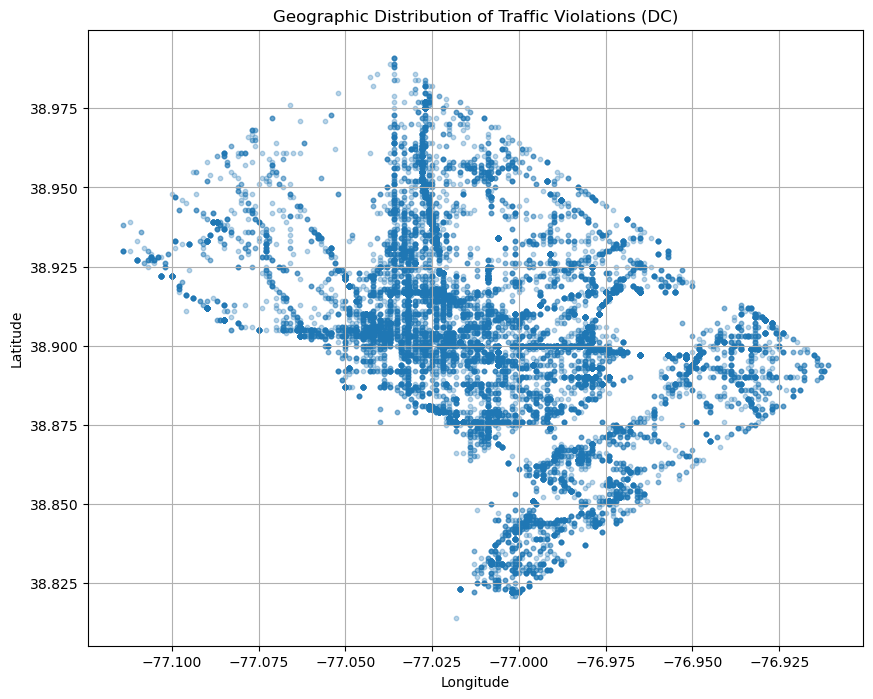

In [13]:
#verify that cluster centers being close together makes sense 
plt.figure(figsize=(10, 8))
plt.scatter(df_clean['LONGITUDE'], df_clean['LATITUDE'], alpha=0.3, s=10)
plt.title("Geographic Distribution of Traffic Violations (DC)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()
